In [1]:
import json
import numpy as np
import requests
import matplotlib.pyplot as plt
from music21 import stream, note as music21_note, meter, tempo
from mido import Message, MidiFile, MidiTrack
import os

### Task 1.1: EDA, Data Collection, Pre-processing, Discussion

#### Task 1.1.1: Context

For task 1, we'll be using the JSB Chorales dataset, which is the entire corpus of 382 fourpart harmonized chorales by J. S. Bach. These compositions were originally intended as harmonizations of Lutheran hymn melodies, written for soprano, alto, tenor, and bass (SATB) voices. The dataset was compiled and formatted by ML researchers in [Modeling Temporal Dependencies in High-Dimensional Sequences: Application to Polyphonic Music Generation and Transcription](https://arxiv.org/pdf/1206.6392), 

The dataset is available [here](https://github.com/czhuang/JSB-Chorales-dataset).

#### Task 1.1.2: Code (discussion below this section)

Let's begin by fetching the overall json for 16ths from the github. We chose to use 16ths as our base unit of time because this would allow us to capture the most possible detail.

In [2]:
url = 'https://raw.githubusercontent.com/czhuang/JSB-Chorales-dataset/master/Jsb16thSeparated.json'
response = requests.get(url)
data = response.json()

Now that we have our data, let's take a look at how it's formatted.

In [3]:
data.keys()

dict_keys(['test', 'train', 'valid'])

In [4]:
print(data['train'][0])

[[74, 70, 65, 58], [74, 70, 65, 58], [74, 70, 65, 58], [74, 70, 65, 58], [75, 70, 58, 55], [75, 70, 58, 55], [75, 70, 60, 55], [75, 70, 60, 55], [77, 69, 62, 50], [77, 69, 62, 50], [77, 69, 62, 50], [77, 69, 62, 50], [77, 70, 62, 55], [77, 70, 62, 55], [77, 69, 62, 55], [77, 69, 62, 55], [75, 67, 63, 48], [75, 67, 63, 48], [75, 69, 63, 48], [75, 69, 63, 48], [74, 70, 65, 46], [74, 70, 65, 46], [74, 70, 65, 46], [74, 70, 65, 46], [72, 69, 65, 53], [72, 69, 65, 53], [72, 69, 65, 53], [72, 69, 65, 53], [72, 69, 65, 53], [72, 69, 65, 53], [72, 69, 65, 53], [72, 69, 65, 53], [74, 70, 65, 46], [74, 70, 65, 46], [74, 70, 65, 46], [74, 70, 65, 46], [75, 69, 63, 48], [75, 69, 63, 48], [75, 67, 63, 48], [75, 67, 63, 48], [77, 65, 62, 50], [77, 65, 62, 50], [77, 65, 60, 50], [77, 65, 60, 50], [74, 67, 58, 55], [74, 67, 58, 55], [74, 67, 58, 53], [74, 67, 58, 53], [72, 67, 58, 51], [72, 67, 58, 51], [72, 67, 58, 51], [72, 67, 58, 51], [72, 65, 57, 53], [72, 65, 57, 53], [72, 65, 57, 53], [72, 65, 

Great. It looks like the data is already preprocessed and in a dictionary pre-split into train, valid, and test sets. Each sequence is a list of note indices, which are MIDI note numbers between 21 and 108 inclusive.

In [5]:
train_data = [np.array(seq, dtype=np.int32) for seq in data['train']]  # 229 sequences
valid_data = [np.array(seq, dtype=np.int32) for seq in data['valid']]  # 76 sequences
test_data = [np.array(seq, dtype=np.int32) for seq in data['test']]    # 77 sequences
print(f"Loaded {len(train_data)} train, {len(valid_data)} valid, "
      f"{len(test_data)} test sequences")

Loaded 229 train, 76 valid, 77 test sequences


Great. Now that we've loaded the data, let's start by taking a peek into the training set to understand the MIDI notes, specifically the silence representation used.

In [6]:
all_notes = np.concatenate([seq.flatten() for seq in train_data])
unique_notes = np.sort(np.unique(all_notes))

ranges = []
start = unique_notes[0]
prev = start

for note in unique_notes[1:]:
    if note > prev + 1:
        ranges.append((start, prev))
        start = note
    prev = note

ranges.append((start, unique_notes[-1]))

for start, end in ranges:
    notes_in_range = unique_notes[(unique_notes >= start) & (unique_notes <= end)]
    if len(notes_in_range) > 1:
        print(f"Notes in the range {start}-{end} exist in dataset")
    else:
        print(f"Note {start} exists in dataset")

Note -1 exists in dataset
Notes in the range 36-81 exist in dataset


It seems like -1 is used as a representation of a rest in the dataset.

Let's move on to visualizing the data, starting with a histogram of the MIDI note values in the training set.

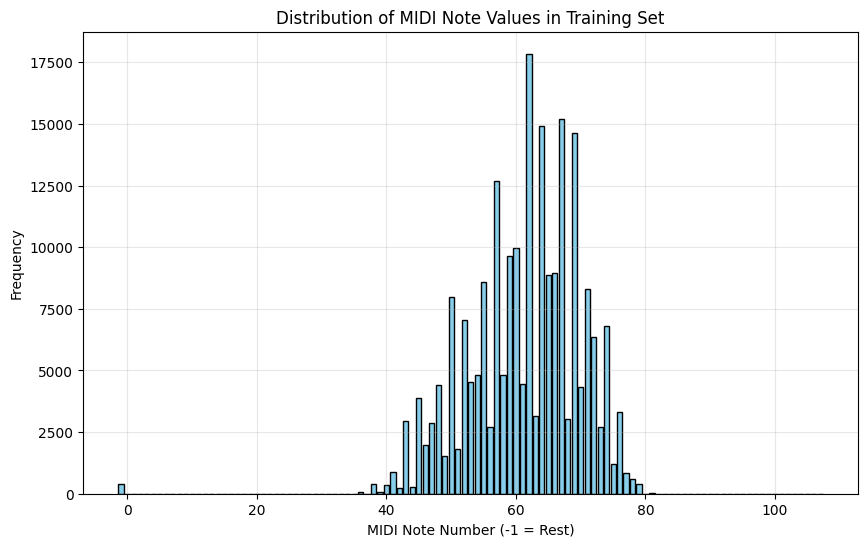

In [7]:
# Visualization 1: Histogram of MIDI Note Values
all_notes = np.concatenate([seq.flatten() for seq in train_data])
plt.figure(figsize=(10, 6))
plt.hist(all_notes, bins=range(-1, 109), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Distribution of MIDI Note Values in Training Set')
plt.xlabel('MIDI Note Number (-1 = Rest)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

Interestingly, it looks like Bach doesn't use too many rests, and he rarely uses the more "extreme" pitches (close to 21 or 108). Let's look at this broken down by voice.

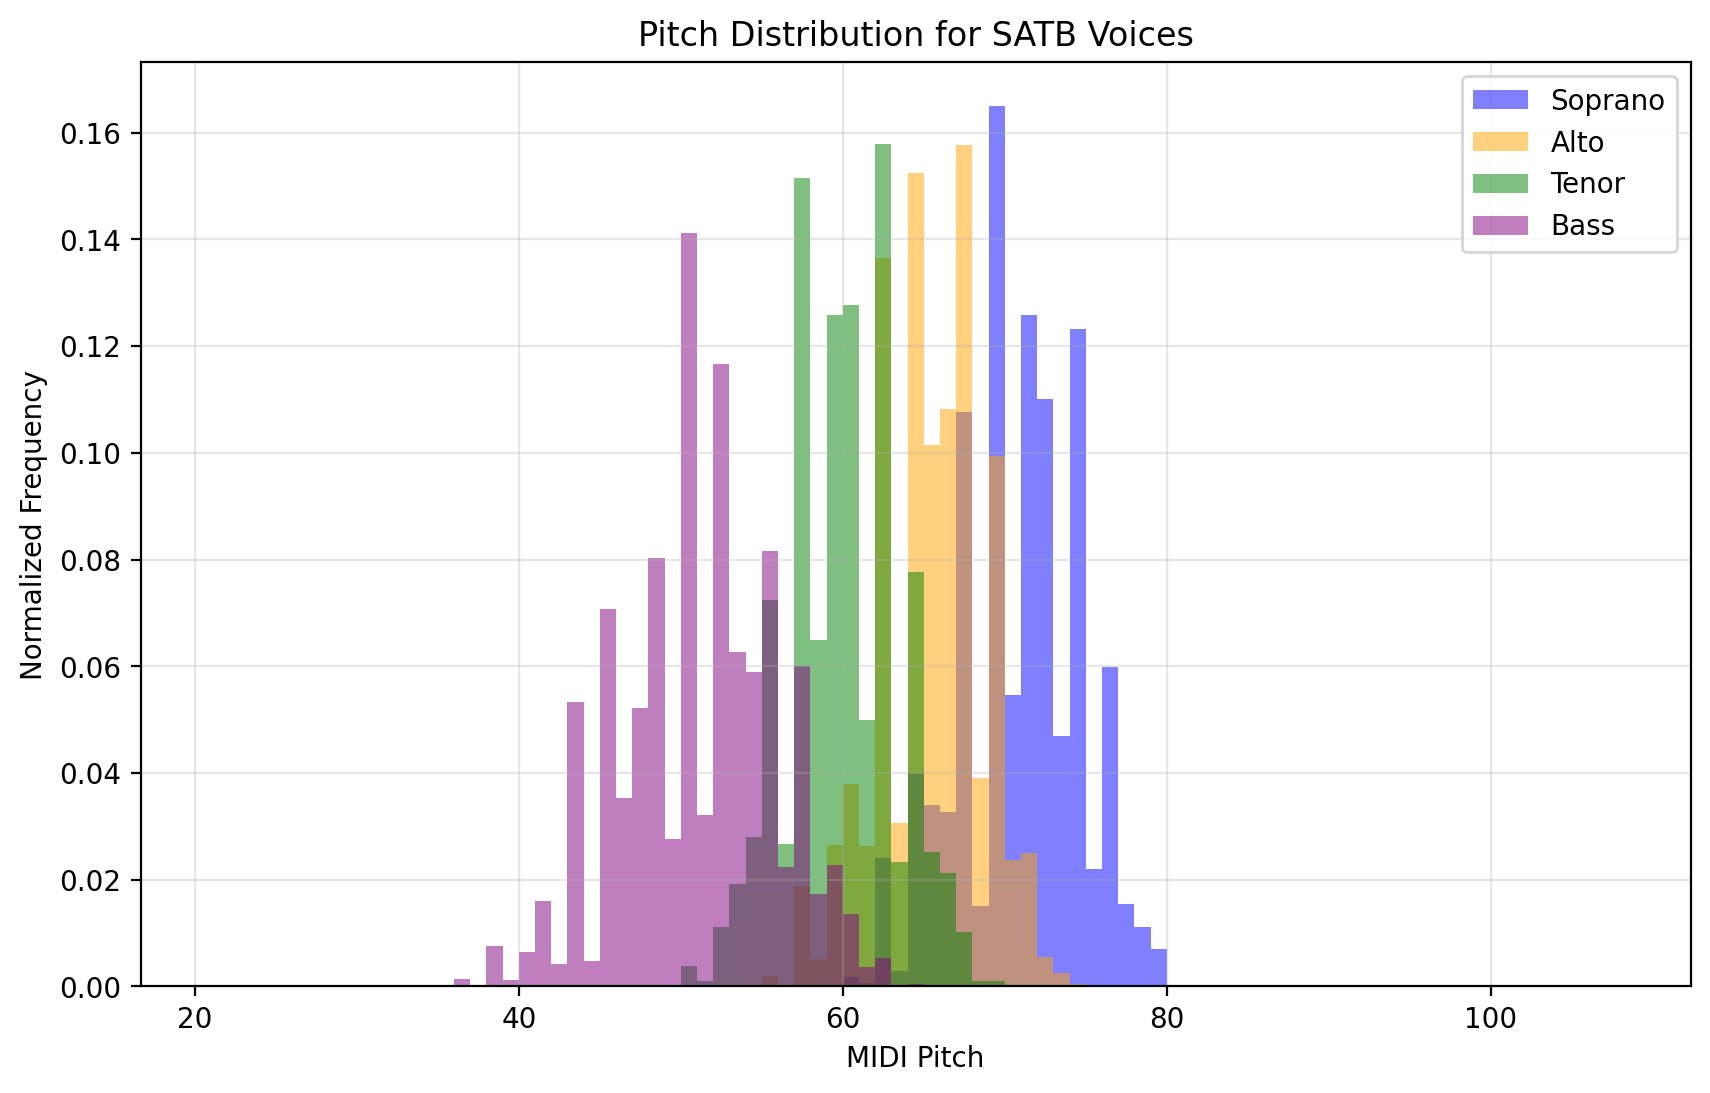

In [8]:
voices = [
    (0, 'Soprano', 'blue'),
    (1, 'Alto', 'orange'),
    (2, 'Tenor', 'green'),
    (3, 'Bass', 'purple')
]

plt.figure(figsize=(10, 6))
for voice_idx, voice_name, color in voices:
    pitches = [t[voice_idx] for seq in train_data for t in seq if t[voice_idx] != -1]
    plt.hist(pitches, bins=range(21, 109), density=True, alpha=0.5, color=color, label=voice_name)

plt.title('Pitch Distribution for SATB Voices')
plt.xlabel('MIDI Pitch')
plt.ylabel('Normalized Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

Interestingly, that "spiky" nature of the pitch distribution seems to be consistent across the voices, which is something to keep an eye on with our generated music.

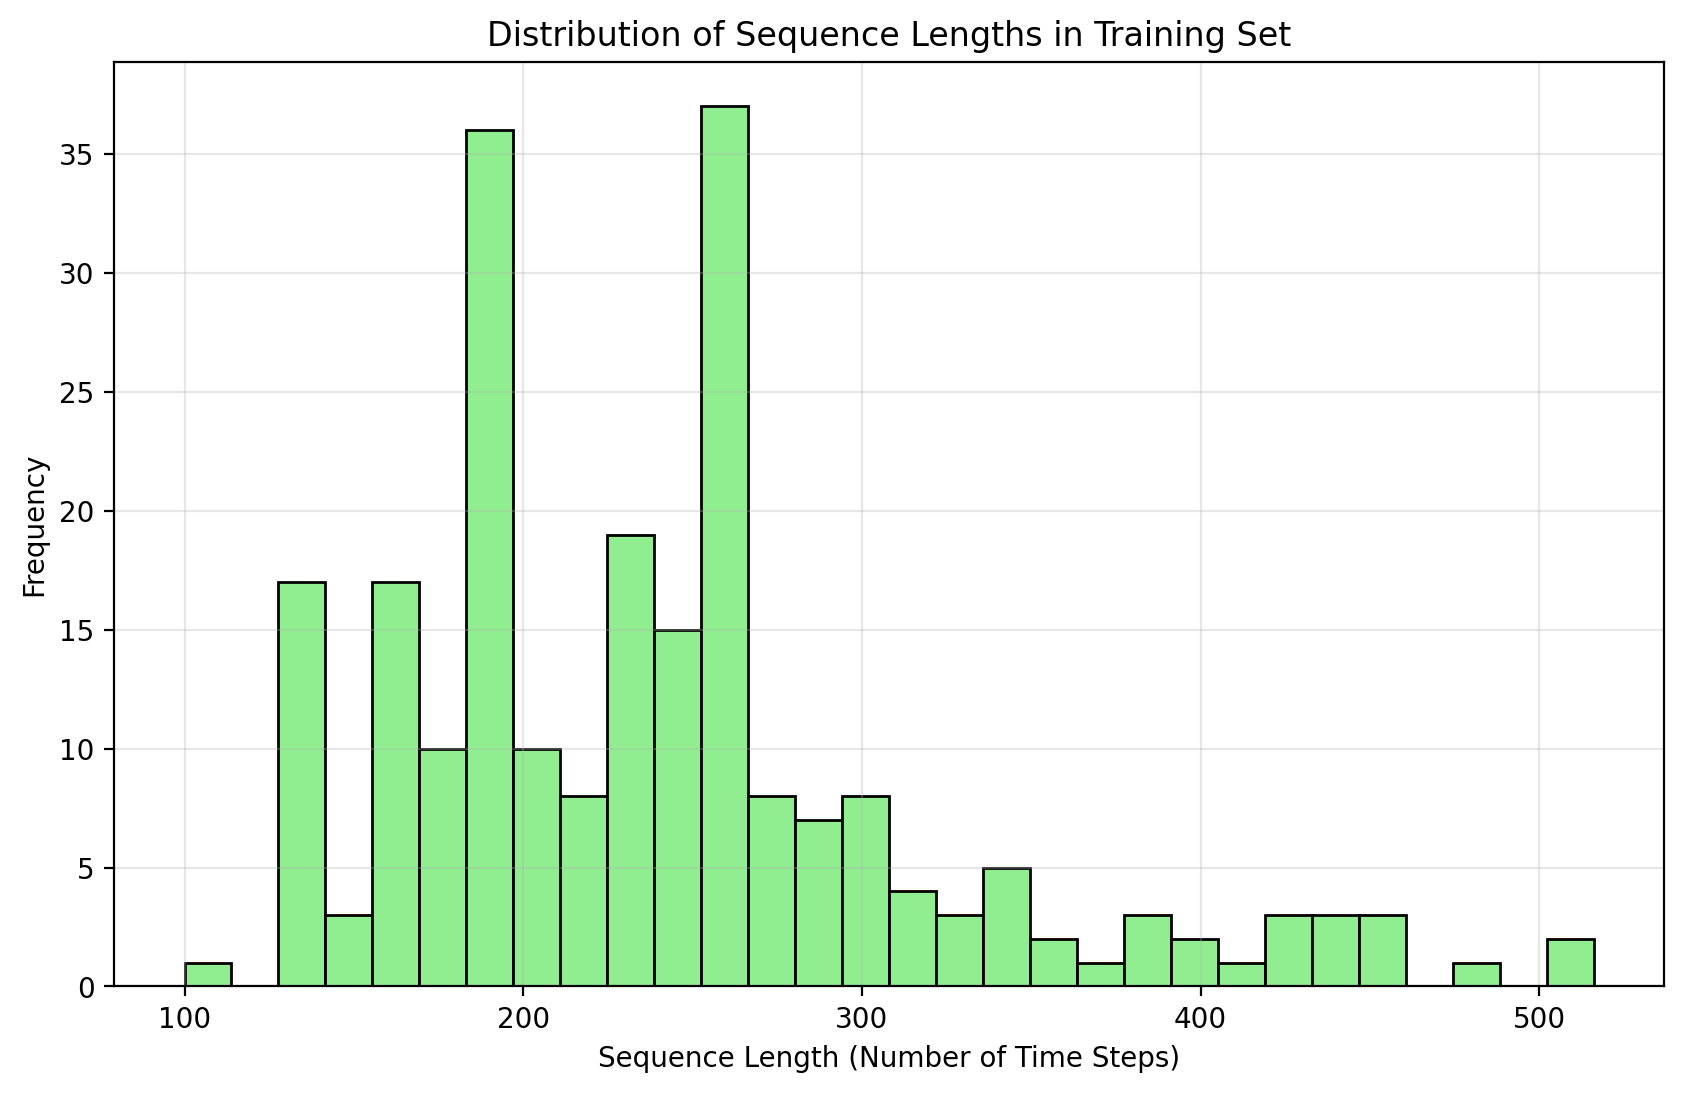

In [9]:
sequence_lengths = [len(seq) for seq in train_data]
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Sequence Lengths in Training Set')
plt.xlabel('Sequence Length (Number of Time Steps)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

Just for funsies, let's make some sheet music out of this dataset.

Created score with 4 parts (voices)
Each part has 192 sixteenth notes
Total duration: 48.0 quarter notes (48.0 measures in 4/4 time)


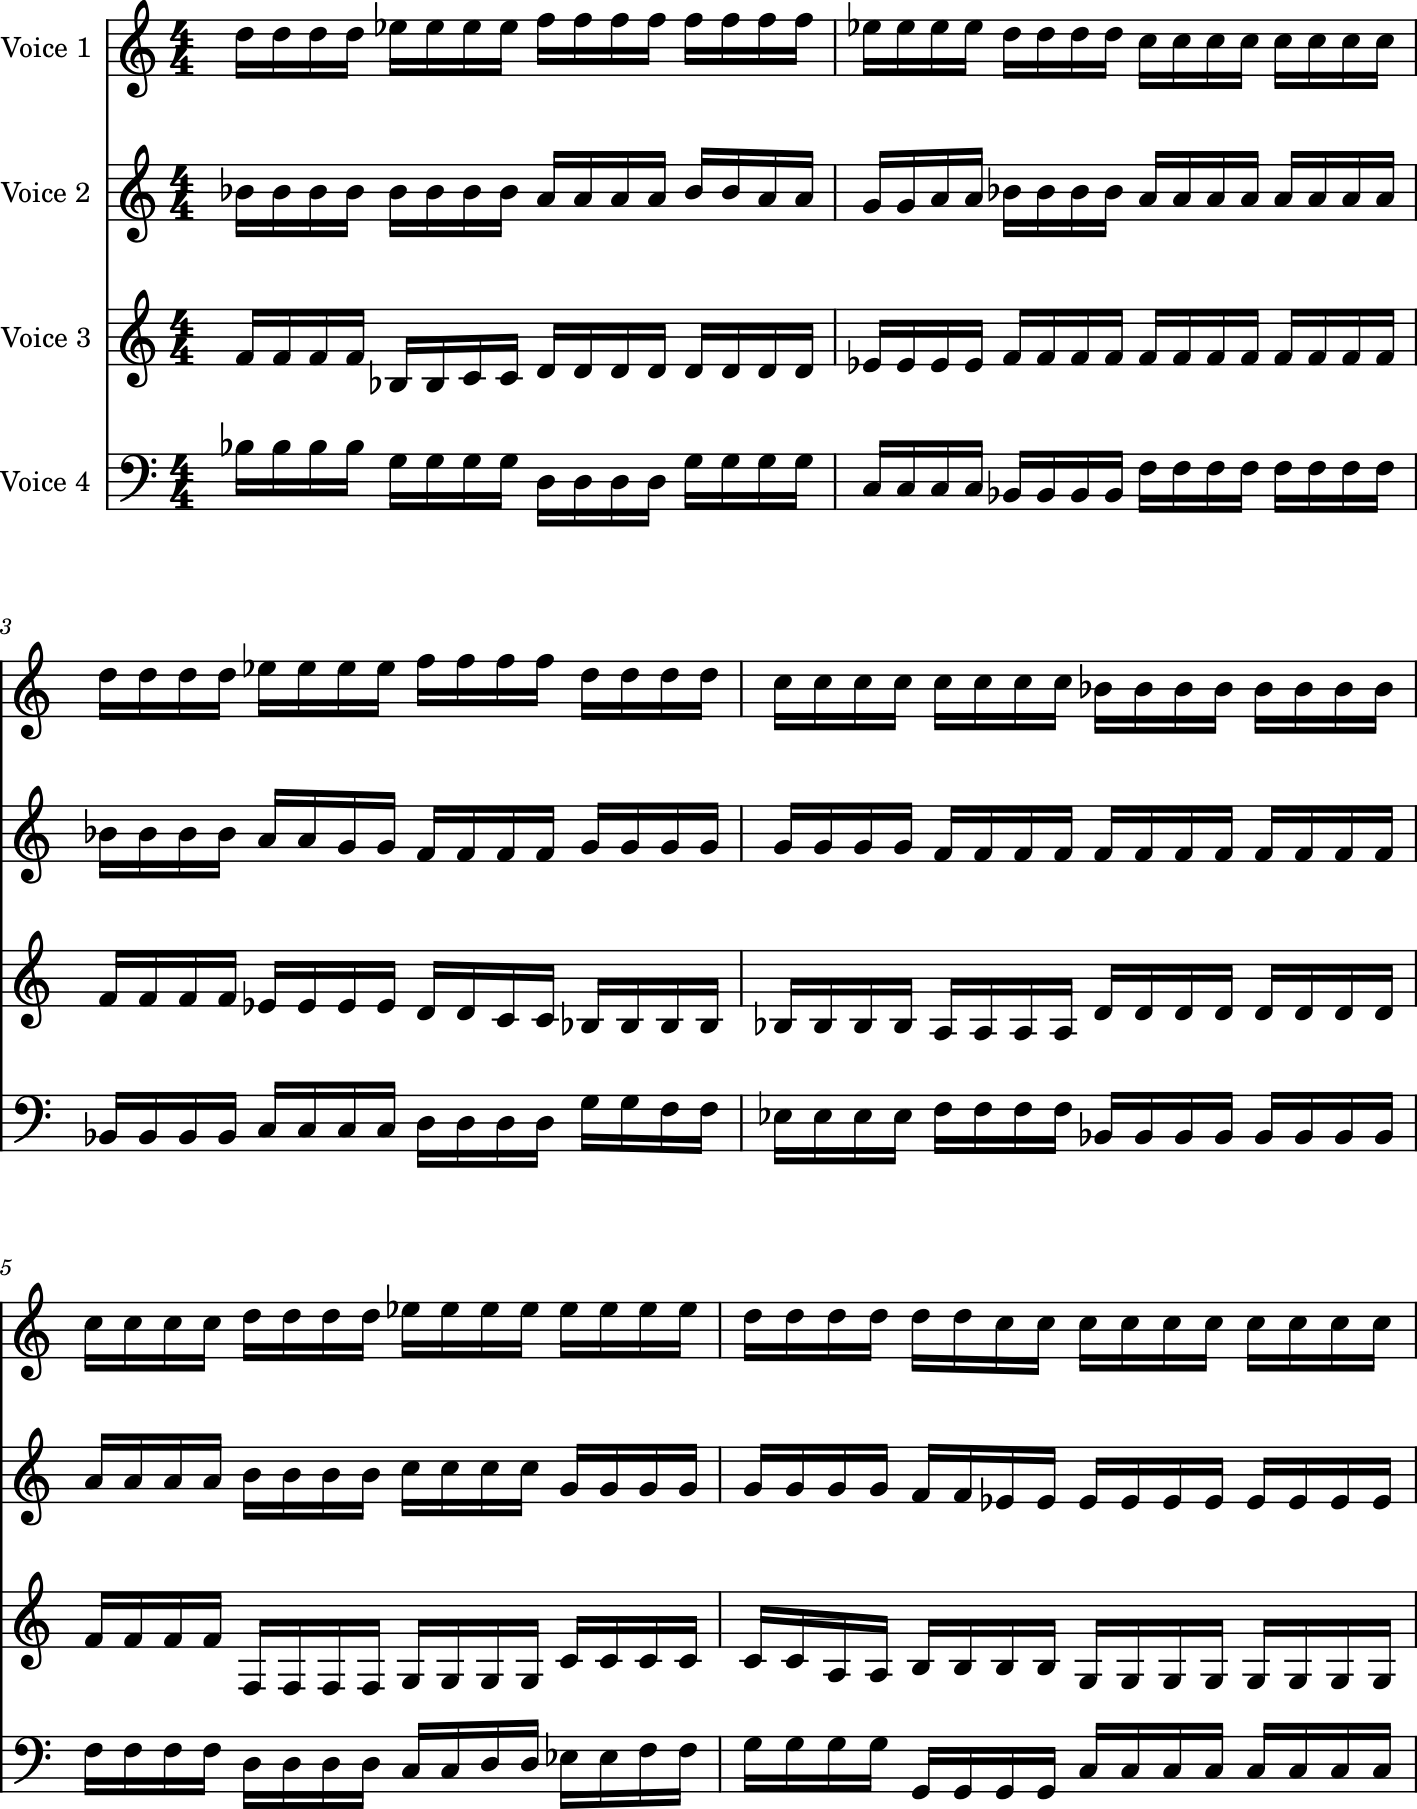

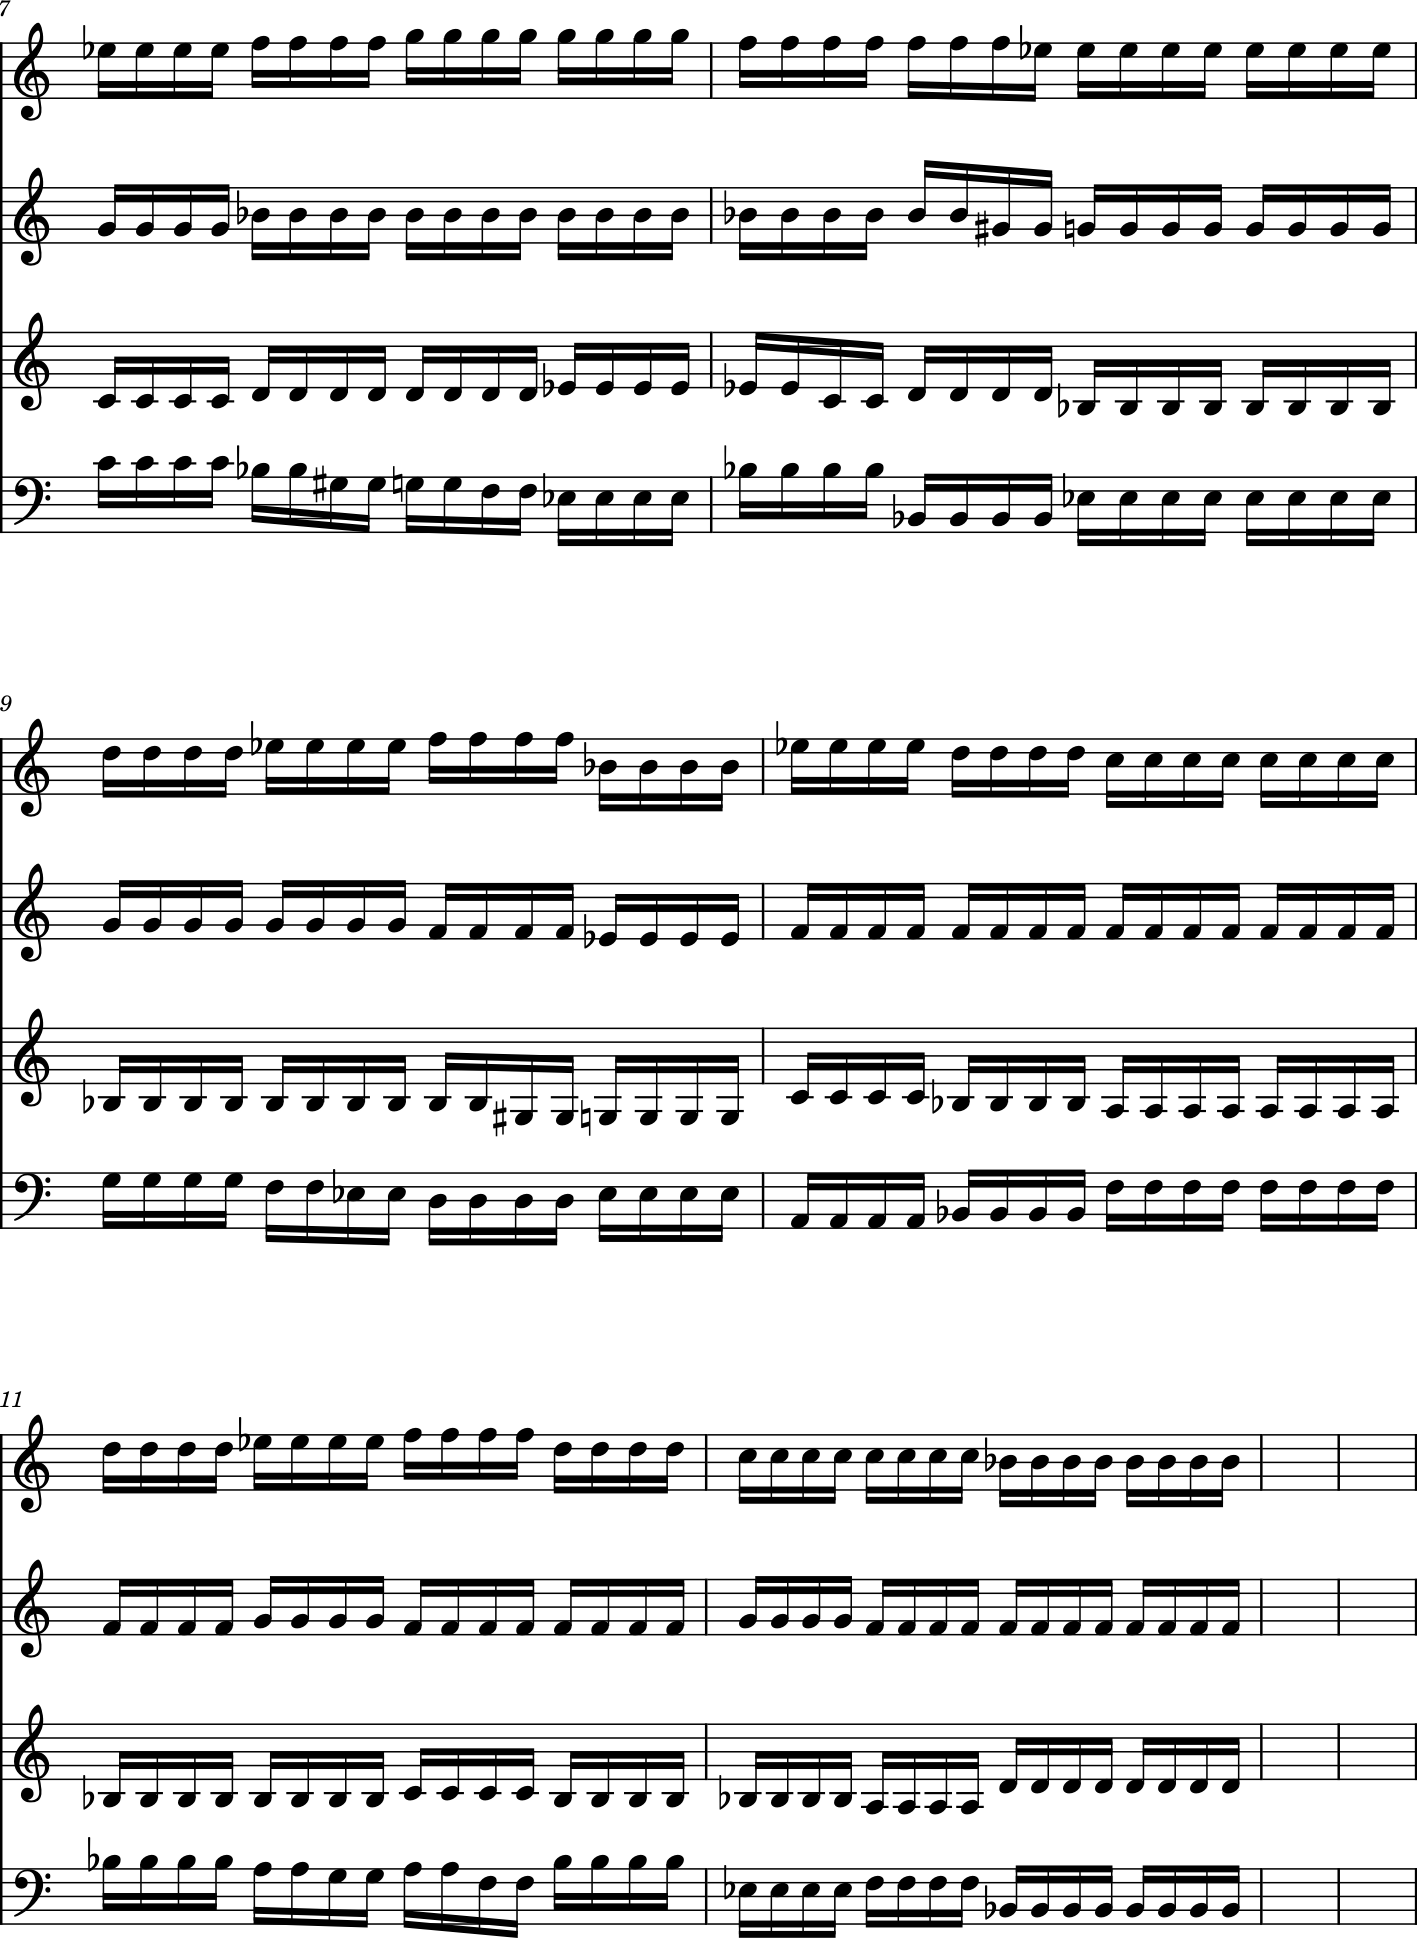

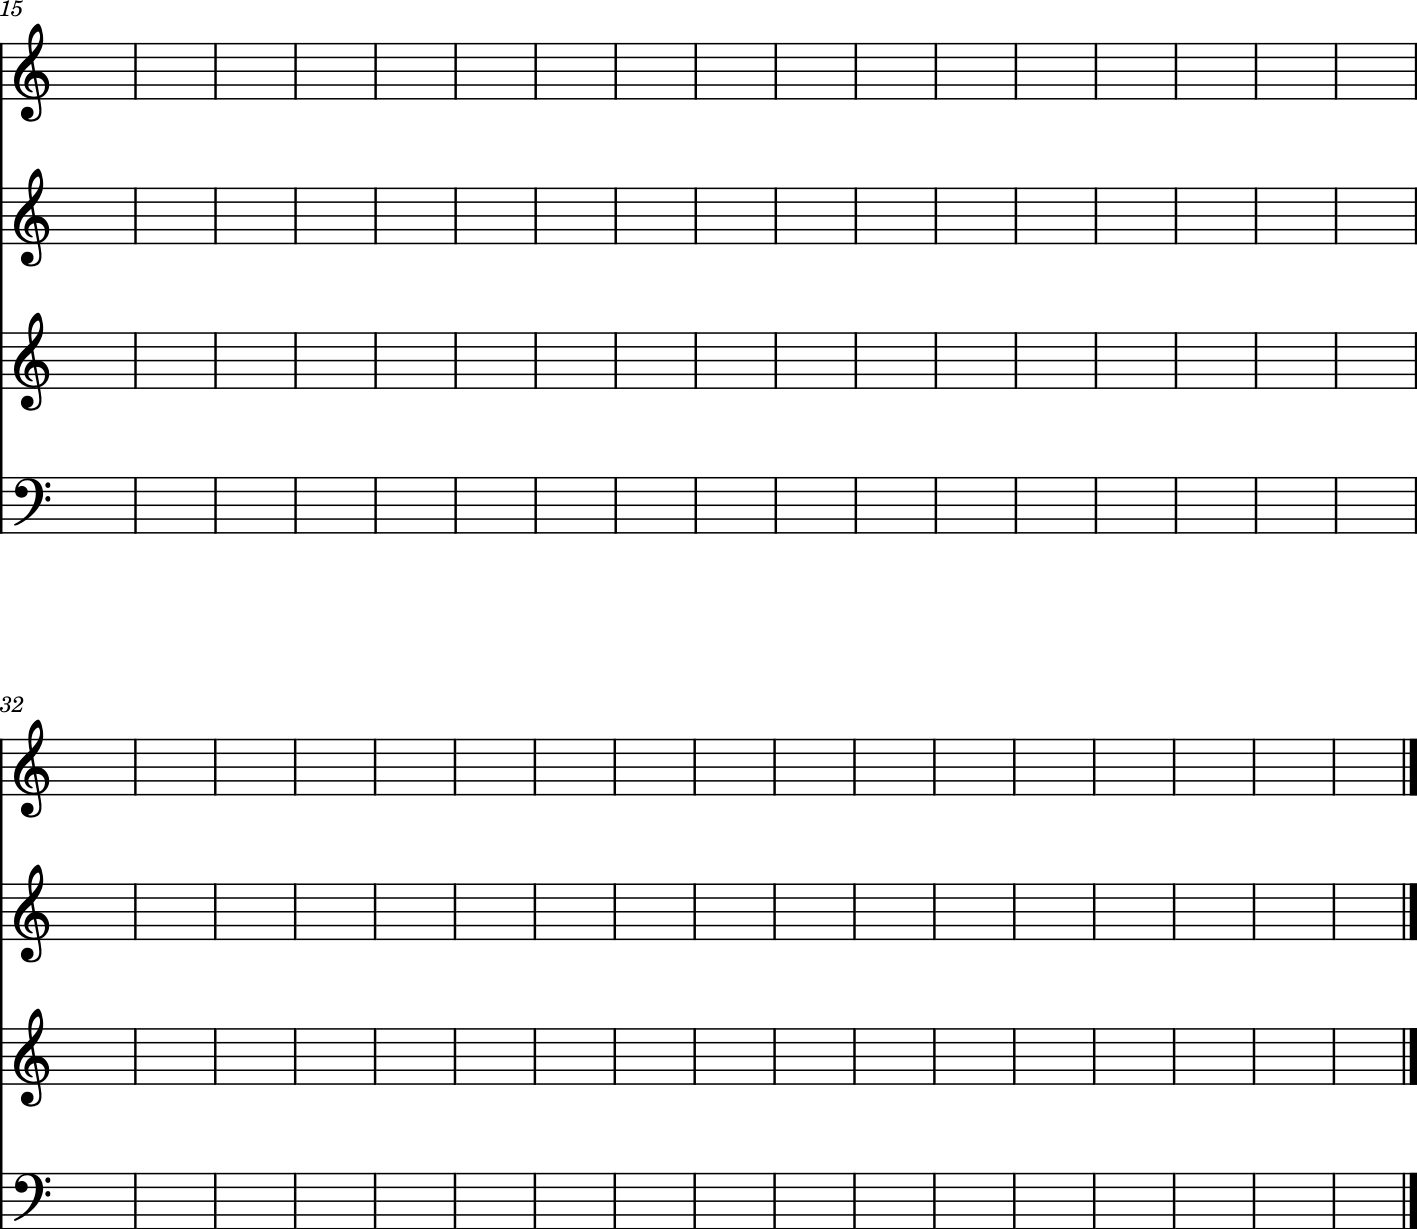


Pitch ranges by voice:
Voice 1: 70 to 79 (MIDI numbers)
  Unique pitches: [70, 72, 74, 75, 77, 79]
Voice 2: 63 to 72 (MIDI numbers)
  Unique pitches: [63, 65, 67, 68, 69, 70, 71, 72]
Voice 3: 53 to 65 (MIDI numbers)
  Unique pitches: [53, 55, 56, 57, 58, 59, 60, 62, 63, 65]
Voice 4: 43 to 60 (MIDI numbers)
  Unique pitches: [43, 45, 46, 48, 50, 51, 53, 55, 56, 57, 58, 60]


In [10]:
sequence = train_data[0]

# Create a music21 stream
score = stream.Score()

# Add time signature (4/4 is common, but adjust if needed)
time_sig = meter.TimeSignature('4/4')
score.append(time_sig)

# Add tempo marking (optional)
tempo_marking = tempo.TempoIndication(number=120)  # 120 BPM
score.append(tempo_marking)

# Create parts for each voice/instrument
# Assuming columns are different voices/instruments playing simultaneously
num_voices = sequence.shape[1]
parts = []

for voice in range(num_voices):
    part = stream.Part()
    part.partName = f'Voice {voice + 1}'
    
    # Extract pitches for this voice
    pitches = sequence[:, voice]
    
    # Create 16th notes for each pitch
    for i, pitch_val in enumerate(pitches):
        n = music21_note.Note()
        n.pitch.midi = int(pitch_val)
        n.quarterLength = 0.25  # 16th note duration
        n.offset = i * 0.25     # Sequential 16th note positions
        part.append(n)
    
    parts.append(part)
    score.append(part)

print(f"Created score with {len(parts)} parts (voices)")
print(f"Each part has {len(sequence)} sixteenth notes")
print(f"Total duration: {len(sequence) * 0.25} quarter notes ({len(sequence) / 4} measures in 4/4 time)")

score.show()

# Show pitch information for each voice
print(f"\nPitch ranges by voice:")
for voice in range(num_voices):
    pitches = sequence[:, voice]
    print(f"Voice {voice + 1}: {min(pitches)} to {max(pitches)} (MIDI numbers)")
    print(f"  Unique pitches: {sorted(set(pitches))}")

Now, let's write all of our data to midi files.

In [11]:
def array_to_midi(data, filename="chords_16th.mid", velocity=64, ticks_per_quarter=480):

    mid = MidiFile(ticks_per_beat=ticks_per_quarter)
    track = MidiTrack()
    mid.tracks.append(track)

    step_time = ticks_per_quarter // 4  # 16th note
    previous_notes = set()

    for row in data:
        # Ensure notes are ints in range 0â€“127
        current_notes = set(int(n) for n in row if 0 <= int(n) <= 127)

        # Turn off notes no longer playing
        for note in previous_notes - current_notes:
            track.append(Message('note_off', note=note, velocity=0, time=0))

        # Turn on new notes
        for note in current_notes - previous_notes:
            track.append(Message('note_on', note=note, velocity=velocity, time=0))

        # Advance time
        if current_notes:
            # Advance on just one note (others use time=0)
            first = list(current_notes)[0]
            track.append(Message('note_off', note=first, velocity=0, time=step_time))
        else:
            # If no notes, still advance time
            track.append(Message('note_off', note=0, velocity=0, time=step_time))

        previous_notes = current_notes

    # Final cleanup
    for note in previous_notes:
        track.append(Message('note_off', note=note, velocity=0, time=0))

    mid.save(filename)

In [12]:
# Create necessary directories if they don't exist
os.makedirs("midi/train", exist_ok=True)
os.makedirs("midi/valid", exist_ok=True)
os.makedirs("midi/test", exist_ok=True)

for i, sequence in enumerate(train_data):
    array_to_midi(sequence, f"midi/train/{i}.mid")
print("Train data saved.")

for i, sequence in enumerate(valid_data):
    array_to_midi(sequence, f"midi/valid/{i}.mid")
print("Validation data saved.")

for i, sequence in enumerate(test_data):
    array_to_midi(sequence, f"midi/test/{i}.mid")
print("Test data saved.")

Train data saved.
Validation data saved.
Test data saved.


#### Task 1.1.3: Discussion

We chose to use the 16th time step from the dataset, given that this would yield the most notes and effectively the most data. Upon downloading the data, we examined the overall structure, verified the keys ("train", "valid", "test"), and explored the distribution of sequence lengths to understand the input characteristics. We preserved the original splits provided, as these are used widely in the community. You can view our histograms for pitch and duration distributions above. 

For downstream processing, each sequence was converted into a MIDI file using a custom conversion function that maps each time step to note-on/note-off events with consistent timing. We also showed sheet music as a sanity check. These MIDI files were then saved into structured directories corresponding to their respective data splits. This preprocessing enabled direct use of the musical data in sequence modeling and generation tasks.